In [1]:
import utils, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 50)

# Random Forests

## Data

Census Income Data Set: http://mlr.cs.umass.edu/ml/datasets/Census+Income

Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

* **age:** continuous.
* **workclass:** Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* **fnlwgt:** continuous.
* **education:** Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* **education-num:** continuous.
* **marital-status:** Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* **occupation:** Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* **relationship:** Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* **race:** White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* **sex:** Female, Male.
* **capital-gain:** continuous.
* **capital-loss:** continuous.
* **hours-per-week:** continuous.
* **native-country:** United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [171]:
df_raw = pd.read_csv('data/census_train.csv')
df_test = pd.read_csv('data/census_test.csv')
df_raw.shape, df_test.shape

((32561, 15), (16281, 15))

In [172]:
df_raw.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [173]:
# La variable "education-num" contiene la misma informacion que "education",
# en tipo numérica y ordenada, por lo que borraremos "education"
# pero guardaremos sus código en "cat_dict".
education_codes = df_raw[['education', 'education-num']].drop_duplicates()
education_codes

,education,education-num
0,Bachelors,13
2,HS-grad,9
3,11th,7
5,Masters,14
6,9th,5
10,Some-college,10
13,Assoc-acdm,12
14,Assoc-voc,11
15,7th-8th,4
20,Doctorate,16


In [174]:
cat_dict = education_codes.set_index('education-num').to_dict()
cat_dict

{'education': {13: ' Bachelors',
  9: ' HS-grad',
  7: ' 11th',
  14: ' Masters',
  5: ' 9th',
  10: ' Some-college',
  12: ' Assoc-acdm',
  11: ' Assoc-voc',
  4: ' 7th-8th',
  16: ' Doctorate',
  15: ' Prof-school',
  3: ' 5th-6th',
  6: ' 10th',
  2: ' 1st-4th',
  1: ' Preschool',
  8: ' 12th'}}

In [176]:
# Borramos "education" y cambiamos el nombre de "education-num" a "education"

# Este estilo de escribir métodos de pandas, seguidos uno de otro, se llama method chaining
df_raw = (df_raw.drop('education', axis=1)
                .rename({'education-num': 'education'}, axis=1))
          
df_raw.head(3)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


## Ejercicio 1: Preprocesar los datos

In [177]:
# 1. Convertir las columnas a tipo "category", ignorar la variable dependiente
for n,col in df_raw.items():
    if not pd.api.types.is_numeric_dtype(col) and n != 'label':
        # Transforma la variable a tipo category
        df_raw[n] = col.astype('category')

        # Actualiza cat_dict
        cat_dict[n] = {i+1:e for i,e in enumerate(df_raw[n].cat.categories)}
        
        
df_raw.dtypes

age                  int64
workclass         category
fnlwgt               int64
education            int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
label               object
dtype: object

In [178]:
# 2. El dataset no tiene data faltante, por que vamos directo a trasnformar
#    las columnas categóricas a numéricas.
df = df_raw.copy()

# Convertir cada columna categórica a numérica
for n,col in df.items():
    if pd.api.types.is_categorical_dtype(col):
        df[n] = col.cat.codes+1
        
df.head(3)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,8,77516,13,5,2,2,5,2,2174,0,40,40,<=50K
1,50,7,83311,13,3,5,1,5,2,0,0,13,40,<=50K
2,38,5,215646,9,1,7,2,5,2,0,0,40,40,<=50K


In [179]:
# 3. Train-validation split
from sklearn.model_selection import train_test_split

x = df.drop('label', axis=1)
y = df['label']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (26048, 13)
Validation shape: (6513, 13)


## Entrenando un Random Forest

In [180]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=10, n_jobs=-1)
m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [181]:
# Vamos a definir una función para ver los resultados del entrenamiento.
def score():
    print(f'Scores:')
    print(f'Train      = {m.score(x_train, y_train):.4}')
    print(f'Validation = {m.score(x_val, y_val):.4}')
    
score()    

Scores:
Train      = 0.9873
Validation = 0.854


In [182]:
# El parámetro "estimators_" del modelo, contiene los árboles entrenados.
# Vamos a obtener las prediciones de cada árbol
preds = np.stack([t.predict(x_val) for t in m.estimators_])
print(preds.shape)
preds

(10, 6513)


array([[0., 1., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

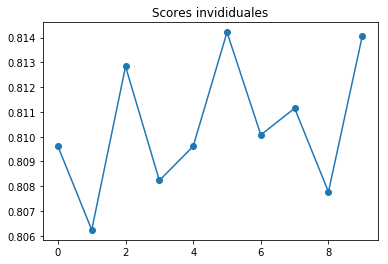

In [183]:
# Veamos el score de cada árbol
from sklearn.metrics import accuracy_score

accs = [accuracy_score(y_val==' >50K', p) for p in preds]
plt.plot(accs, '-o')
plt.title('Scores invididuales');

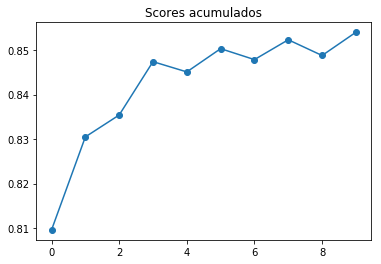

In [184]:
# Ahora veamos el score acumulado
acum_accs = [accuracy_score(y_val==' >50K', np.mean(preds[:i+1,:], axis=0) > 0.5) for i in range(len(preds))]
plt.plot(acum_accs, '-o')
plt.title('Scores acumulados');

In [186]:
# Usemos los árboles para obtener una predicción con una estimación de confianza.
sample = x_val.sample(1)

pred = np.stack([t.predict(sample) for t in m.estimators_])

pred.mean() > 0.5, pred.std()

(False, 0.4898979485566356)

In [187]:
pred

array([[0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.]])

## Out-of-bag (OOB) score

¿Nuestra validación es peor en el conjunto de validación debido a overfitting, o es porque el conjunto de validación es para un período de tiempo diferente, o un poco de ambos?

Con la información existente que hemos mostrado, no podemos decirlo. Sin embargo, los bosques aleatorios tienen un truco muy ingenioso: oobs core (error fuera de la bolsa).

La idea es calcular el error en el conjunto de entrenamiento, donde la predicción de cada elemento se haga sólo por los árboles que no lo incluyeron en su entrenamiento. Esto nos permite ver si el modelo se ajusta demasiado, sin necesidad de un conjunto de validación por separado.

In [188]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [189]:
m.oob_score_

0.8504683660933661

In [190]:
# Vamos a modificar la función score, para incluir el oob score.
def score():
    print(f'Scores:')
    print(f'Train      = {m.score(x_train, y_train):.4}')
    print(f'Validation = {m.score(x_val, y_val):.4}')
    if hasattr(m, 'oob_score_'): print(f'OOB        = {m.oob_score_:.4}')
    
score()    

Scores:
Train      = 0.9993
Validation = 0.862
OOB        = 0.8505


**Algunos paŕametros importantes al crear un Random Forest:**
* n_estimators: cantidad de árboles
* max_depth: la máxima profundidad de cada árbol
* min_samples_leaf: cantidad de muestras mínimas para que puede tener una rama.
* max_features: cantidad de columnas que ve cada árbol.

# Regresión

House Sales Prediction Data Set: https://www.kaggle.com/harlfoxem/housesalesprediction/home

Abstract: This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

- **id**: a notation for a house
- **date**: Date house was sold
- **price**: Price is prediction target
- **bedrooms**: Number of Bedrooms/House
- **bathrooms**: Number of bathrooms/bedrooms
- **sqft_living**: square footage of the home
- **sqft_lot**: square footage of the lot
- **floors**: Total floors (levels) in house
- **waterfront**: House which has a view to a waterfront
- **view**: Has been viewed
- **condition**: How good the condition is ( Overall )
- **grade**: overall grade given to the housing unit, based on King County grading system
- **sqft_above**: square footage of house apart from basement
- **sqft_basement**: square footage of the basement
- **yr_built**: Built Year
- **yr_renovated**: Year when house was renovated
- **zipcode**: zip
- **lat**: Latitude coordinate
- **long**: Longitude coordinate
- **sqft_living15**: Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
- **sqft_lot15**: lotSize area in 2015(implies-- some renovations)

In [303]:
df_raw = pd.read_csv('data/kc_house_data.csv', parse_dates=['date'])
print(df_raw.shape)
df_raw.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [304]:
# Borramos la variable "id"
df_raw.drop('id', axis=1, inplace=True)
df_raw.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Preprocess

### El target

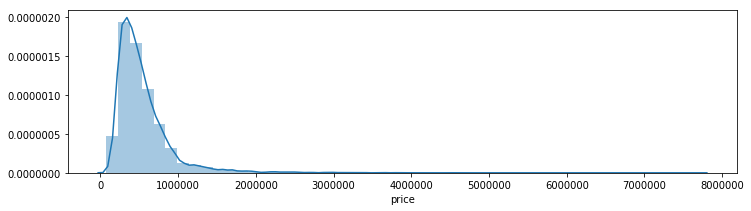

In [305]:
plt.figure(figsize=(12,3))
sns.distplot(df_raw.price);

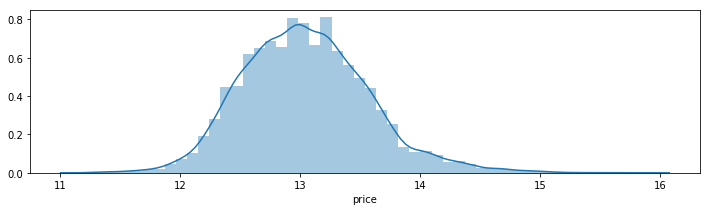

In [306]:
plt.figure(figsize=(12,3))
sns.distplot(np.log(df_raw.price));

Es importante tener en cuenta lo que estamos evaluando, en el caso de precios es bastante común tener mayor interes en el ratio del error que en el valor del error.

* La predicción fallo en S/.10 vs la predicción fallo en 10%.
* Un error de S/.100 en un precio de S/.1,000,000 vs un error de S/.100 en un precio de S/.1000.

Por eso vamos a considerar el **log** del precio.

In [307]:
df_raw.price = np.log(df_raw.price)
df_raw.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,12.309982,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,13.195614,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2015-02-25,12.100712,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2014-12-09,13.311329,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,13.142166,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Fechas

In [308]:
df_raw.date.describe()

count                   21613
unique                    372
top       2014-06-23 00:00:00
freq                      142
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

In [309]:
# Podemos usar "dt" para acceder a los métodos de fechas.
df_raw.date.dt.year.head()

0    2014
1    2014
2    2015
3    2014
4    2015
Name: date, dtype: int64

In [310]:
# Si queremos acceder al atributo "year" desde una variable string usamos "getattr()"
getattr(df_raw.date.dt, "year").head()

0    2014
1    2014
2    2015
3    2014
4    2015
Name: date, dtype: int64

In [311]:
# 1. Vamos a extrarer los parámetros útiles que se pueden extraer de fechas
date_attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
             'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

for n in date_attr:
    df_raw['date_' + n] = getattr(df_raw['date'].dt, n.lower())

# 2. Agregamos una columan con una representación numérica de la fecha
df_raw['date_elapsed'] = df_raw['date'].astype(np.int64) // 10 ** 9


# 3. Eliminamos la variable date
df_raw.drop('date', axis=1, inplace=True)

df_raw.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_Year,date_Month,date_Week,date_Day,date_Dayofweek,date_Dayofyear,date_Is_month_end,date_Is_month_start,date_Is_quarter_end,date_Is_quarter_start,date_Is_year_end,date_Is_year_start,date_elapsed
0,12.309982,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,42,13,0,286,False,False,False,False,False,False,1413158400
1,13.195614,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,50,9,1,343,False,False,False,False,False,False,1418083200
2,12.100712,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,9,25,2,56,False,False,False,False,False,False,1424822400
3,13.311329,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,50,9,1,343,False,False,False,False,False,False,1418083200
4,13.142166,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,8,18,2,49,False,False,False,False,False,False,1424217600


In [312]:
# Veamos la cantidad de valores únicos de las variables que hemos creado
df_raw[['date_'+e for e in date_attr]].nunique()

date_Year                  2
date_Month                12
date_Week                 52
date_Day                  31
date_Dayofweek             7
date_Dayofyear           356
date_Is_month_end          2
date_Is_month_start        2
date_Is_quarter_end        2
date_Is_quarter_start      2
date_Is_year_end           2
date_Is_year_start         1
dtype: int64

In [313]:
# Vamos a eliminar "date_Is_year_start" dado que tiene el mismo valor para todo el dataset
df_raw.drop('date_Is_year_start', axis=1, inplace=True)

### Train-validation split

In [314]:
x = df_raw.drop('price', axis=1)
y = df_raw['price']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (17290, 30)
Validation shape: (4323, 30)


## Entrenar un árbol de regresión

In [315]:
from sklearn.tree import DecisionTreeRegressor

m = DecisionTreeRegressor(max_depth=2)
m.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [316]:
# m.score retorna el coeficiente de determinación de la predicción
score()

Scores:
Train      = 0.5539
Validation = 0.5383


In [317]:
# veamos el mse
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, m.predict(x_train)), mean_squared_error(y_val, m.predict(x_val))

(0.1228812589234029, 0.1315939214603434)

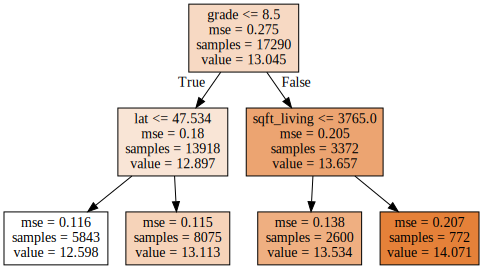

In [318]:
utils.draw_tree(m, x_train)

## Calculando los valores del árbol

In [319]:
y_train.mean()

13.045165229875252

In [320]:
((y_train - y_train.mean())**2).mean()

0.27543630032941563

In [321]:
y_train[x_train['grade'] <= 8.5].mean()

12.896989327477723

In [322]:
((y_train[x_train['grade'] <= 8.5] - y_train[x_train['grade'] <= 8.5].mean())**2).mean()

0.17996169928110842

In [323]:
y_train[x_train['grade'] > 8.5].mean()

13.656764343033267

In [324]:
((y_train[x_train['grade'] > 8.5] - y_train[x_train['grade'] > 8.5].mean())**2).mean()

0.2048319724186241

## Usando un random forest

In [325]:
from sklearn.ensemble import RandomForestRegressor
m = RandomForestRegressor(40, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [326]:
score()

Scores:
Train      = 0.983
Validation = 0.8882
OOB        = 0.8775


# Interpretación del modelo

## Feature importance

### Sklearn feature importance (mean decrease impurity)

In [41]:
m.feature_importances_

array([2.03670355e-03, 4.50843424e-03, 1.72523499e-01, 1.40612542e-02,
       1.21074770e-03, 5.87445038e-03, 7.40117341e-03, 4.38675470e-03,
       3.45969818e-01, 1.33080438e-02, 2.53301263e-03, 1.96107427e-02,
       1.00683370e-03, 1.01554808e-02, 2.89542932e-01, 4.22852358e-02,
       2.47588867e-02, 1.24132174e-02, 2.20282307e-04, 1.50441244e-03,
       3.13706288e-03, 5.61963128e-03, 2.76062033e-03, 4.61702482e-03,
       1.19727452e-04, 1.39722637e-04, 6.93801285e-05, 5.70974133e-05,
       3.34979522e-06, 0.00000000e+00, 8.16446745e-03])

In [42]:
imp = pd.DataFrame({'cols':x_train.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
imp.style.bar()

,cols,imp
8,grade,0.34597
14,lat,0.289543
2,sqft_living,0.172523
15,long,0.0422852
16,sqft_living15,0.0247589
11,yr_built,0.0196107
3,sqft_lot,0.0140613
9,sqft_above,0.013308
17,sqft_lot15,0.0124132
13,zipcode,0.0101555


### Permutation importance

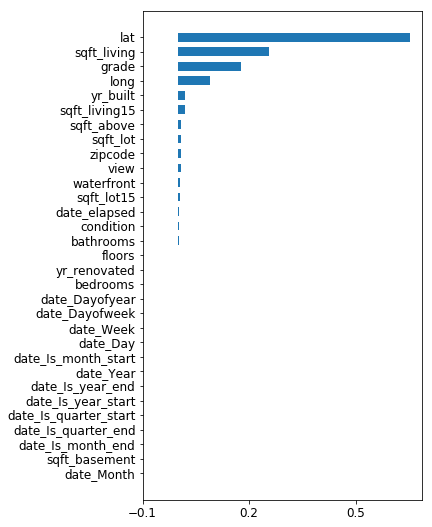

CPU times: user 2.15 s, sys: 65 ms, total: 2.22 s
Wall time: 3.86 s


In [79]:
%%time
from rfpimp import importances, plot_importances

imp = importances(m, x_val, y_val)
plot_importances(imp, figsize=(5,9));

### Drop-column importance

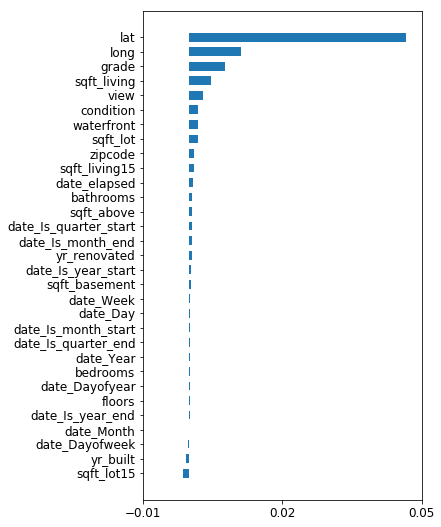

CPU times: user 3min 52s, sys: 803 ms, total: 3min 53s
Wall time: 1min 8s


In [80]:
%%time
from rfpimp import dropcol_importances

imp = dropcol_importances(m, x_train, y_train)
plot_importances(imp, figsize=(5,9));

## Partial Dependence Plot

- **id**: a notation for a house
- **date**: Date house was sold
- **price**: Price is prediction target
- **bedrooms**: Number of Bedrooms/House
- **bathrooms**: Number of bathrooms/bedrooms
- **sqft_living**: square footage of the home
- **sqft_lot**: square footage of the lot
- **floors**: Total floors (levels) in house
- **waterfront**: House which has a view to a waterfront
- **view**: Has been viewed
- **condition**: How good the condition is ( Overall )
- **grade**: overall grade given to the housing unit, based on King County grading system
- **sqft_above**: square footage of house apart from basement
- **sqft_basement**: square footage of the basement
- **yr_built**: Built Year
- **yr_renovated**: Year when house was renovated
- **zipcode**: zip
- **lat**: Latitude coordinate
- **long**: Longitude coordinate
- **sqft_living15**: Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
- **sqft_lot15**: lotSize area in 2015(implies-- some renovations)

In [83]:
from pdpbox import pdp, info_plots

df_train = x_train.assign(price=y_train)
df_train.head(2)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_Year,date_Month,date_Week,date_Day,date_Dayofweek,date_Dayofyear,date_Is_month_end,date_Is_month_start,date_Is_quarter_end,date_Is_quarter_start,date_Is_year_end,date_Is_year_start,date_elapsed,price
6325,3,1.75,1780,13095,1.0,0,0,4,9,1780,0,1983,0,98042,47.367,-122.152,2750,13095,2014,5,22,27,1,147,False,False,False,False,False,False,1401148800,12.691580
13473,2,1.00,1000,3700,1.0,0,0,3,6,800,200,1929,0,98118,47.552,-122.290,1270,5000,2015,3,11,10,1,69,False,False,False,False,False,False,1425945600,12.456831


### Examinemos la variable "yr_built"

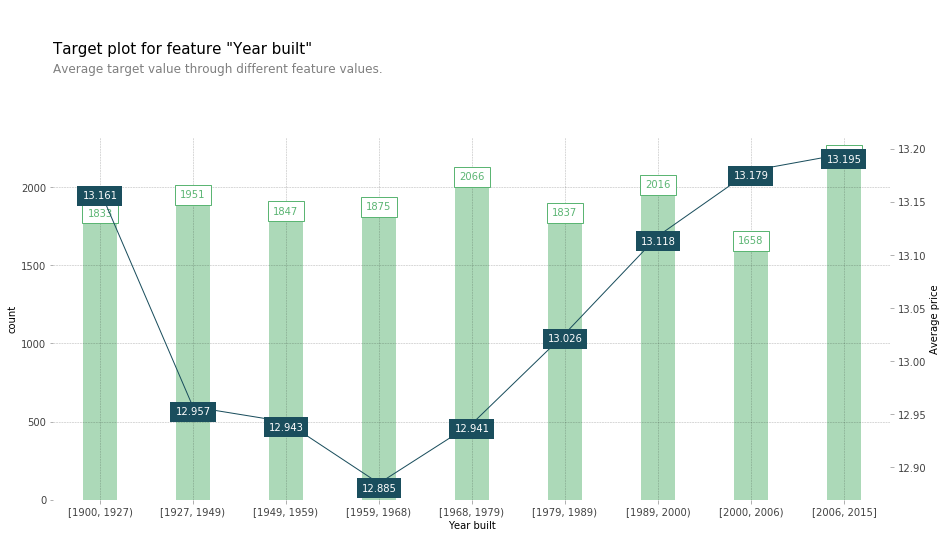

In [84]:
# Veamos como se distribuye en la data que tenemos, con respecto a nuestro target
info_plots.target_plot(df_train, 'yr_built', 'Year built', 'price');

In [87]:
# Ahora veamos como reacciona el modelo a esta variable
pdp_year_built = pdp.pdp_isolate(m, x_train, x_train.columns, 'yr_built')

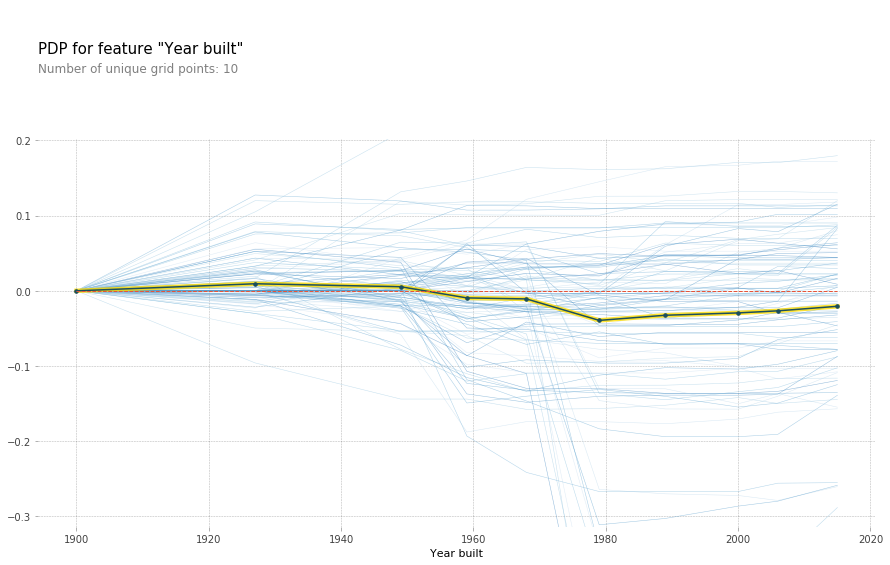

In [94]:
pdp.pdp_plot(pdp_year_built, 'Year built', plot_lines=True, frac_to_plot=100);

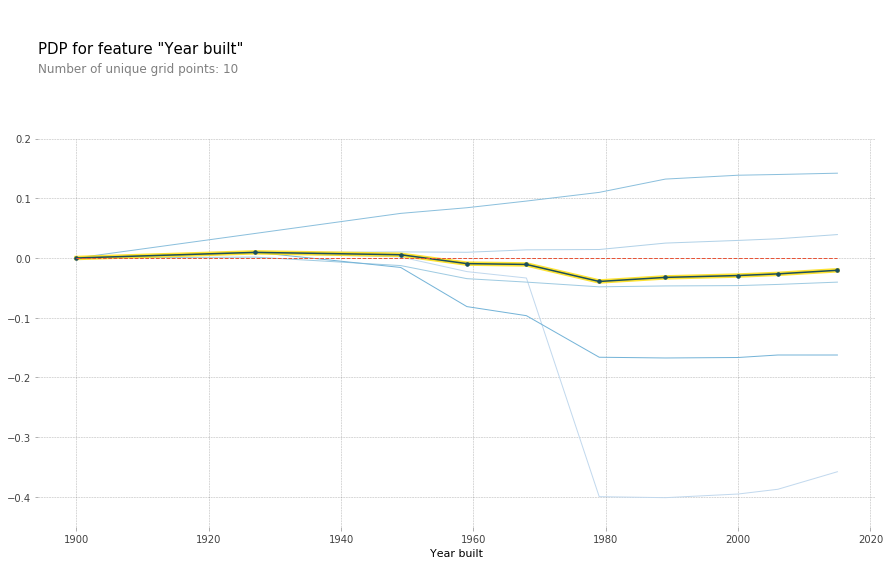

In [80]:
# Usamos la opción de clusters para agrupar mejor los comportamientos
fig, axes = pdp.pdp_plot(pdp_year_built, 'Year built', cluster=True, n_cluster_centers=5)
axes['pdp_ax'].set_ylim(-0.45,0.2);

### Veamos las interacciones entre longitud y latitud

In [111]:
pdp_lat_long = pdp.pdp_interact(m, x_train, x_train.columns, ['long', 'lat'])

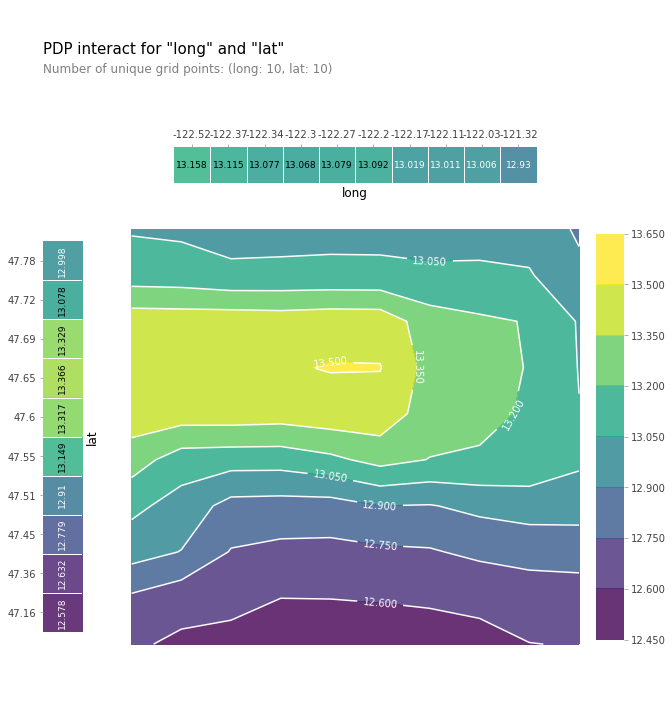

In [117]:
pdp.pdp_interact_plot(pdp_lat_long, ['long', 'lat'], plot_pdp=True);

## Tree interpreter

In [236]:
from treeinterpreter import treeinterpreter as ti

sample = x_val.sample()
print(f'Real price = {y_val[sample.index[0]]}')
sample

Real price = 14.093142294562554


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_Year,date_Month,date_Week,date_Day,date_Dayofweek,date_Dayofyear,date_Is_month_end,date_Is_month_start,date_Is_quarter_end,date_Is_quarter_start,date_Is_year_end,date_Is_year_start,date_elapsed
7536,4,3.0,2120,3600,2.0,0,3,4,8,1830,290,1908,1996,98119,47.6344,-122.369,2120,3600,2014,12,51,20,5,354,False,False,False,False,False,False,1419033600


In [237]:
preds, bias, contributions = ti.predict(m, sample)

In [238]:
# Predicción final
preds

array([13.6414084])

In [239]:
# Bias inicial
bias

array([13.04555006])

In [240]:
# Contribuciones de cada variable
contributions

array([[-3.16159203e-03,  2.03414082e-02,  6.38170631e-02,
        -2.69453380e-03,  7.74784393e-03,  0.00000000e+00,
        -2.00218957e-03,  5.61156517e-03, -1.16673818e-01,
         5.19588020e-02,  3.36895797e-03,  5.78505400e-02,
         1.14284111e-02, -1.50036341e-02,  4.11542264e-01,
         5.33375978e-02,  9.22139631e-02,  2.58478712e-03,
         0.00000000e+00, -3.02214367e-03, -1.46487105e-02,
         6.00833936e-04, -1.22190307e-02, -2.13358764e-02,
        -3.80433663e-04, -7.71668326e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.36793806e-03]])

In [241]:
# Veamos las contribuciones con el nombre de las variables
tt = pd.DataFrame(contributions, columns=sample.columns).T.sort_values(0)
tt.style.background_gradient(cmap='YlOrRd')

,0
grade,-0.116674
date_Dayofyear,-0.0213359
zipcode,-0.0150036
date_Week,-0.0146487
date_Dayofweek,-0.012219
bedrooms,-0.00316159
date_Month,-0.00302214
sqft_lot,-0.00269453
view,-0.00200219
date_Is_month_start,-0.000771668


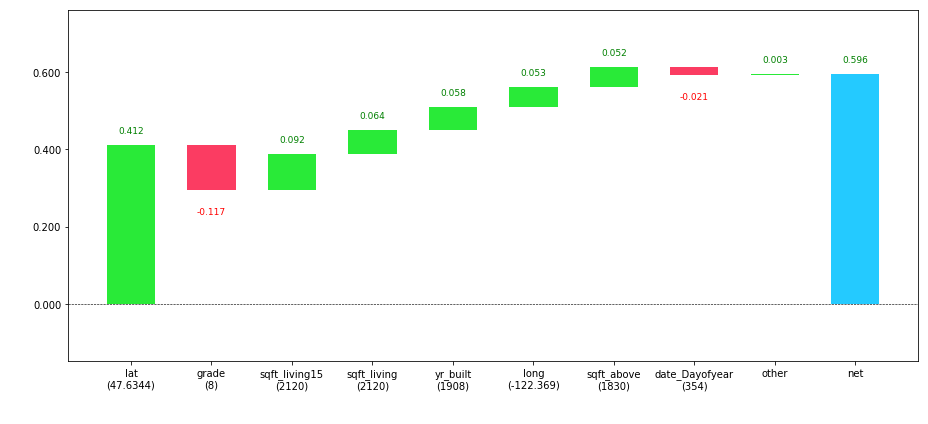

In [242]:
# Usamos un waterfallplot para tener una mejor visualización de la predicción
utils.waterfallplot(sample, contributions[0], formatting='{:,.3f}', size=(13,6), sorted_value=True, threshold=0.05);

## Ejercicio 2: Utilizar los métodos de interpretación en el Census Income Data Set

* **age:** continuous.
* **workclass:** Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* **fnlwgt:** continuous.
* **education:** Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* **education-num:** continuous.
* **marital-status:** Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* **occupation:** Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* **relationship:** Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* **race:** White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* **sex:** Female, Male.
* **capital-gain:** continuous.
* **capital-loss:** continuous.
* **hours-per-week:** continuous.
* **native-country:** United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

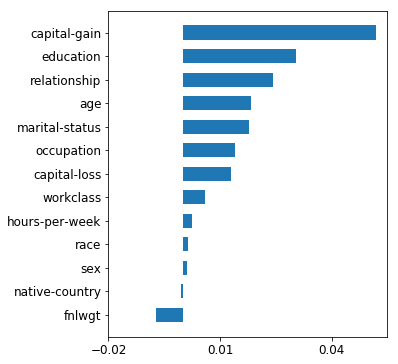

In [191]:
# Cargar la data del ejemplo de clasificación
from rfpimp import importances, plot_importances

# imp = importances(m, x_val, y_val)
plot_importances(imp, figsize=(5,6));

In [192]:
from pdpbox import pdp, info_plots

df_train = x_train.assign(label=y_train==' >50K')
df_train.head(2)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
5514,33,3,198183,13,5,11,2,5,1,0,0,50,40,True
19777,36,5,86459,11,3,5,1,5,2,0,1887,50,40,True


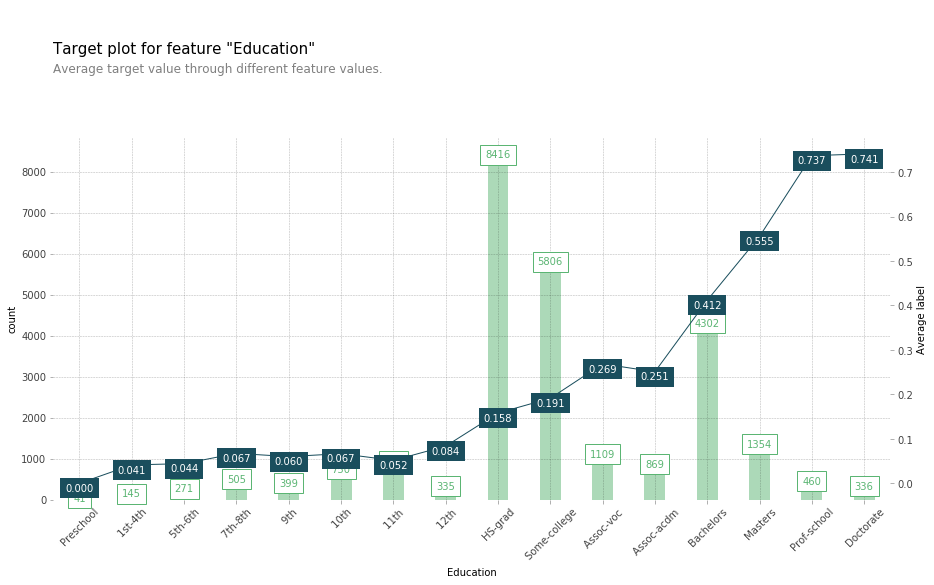

In [208]:
education_lbls = [cat_dict['education'][i+1] for i in range(16)]
fig, axes, summary_df = info_plots.target_plot(df_train, 'education', 'Education', 'label', grid_type='equal',
                       num_grid_points=df_train.education.nunique()+1);
axes['bar_ax'].set_xticklabels(education_lbls, rotation=45);

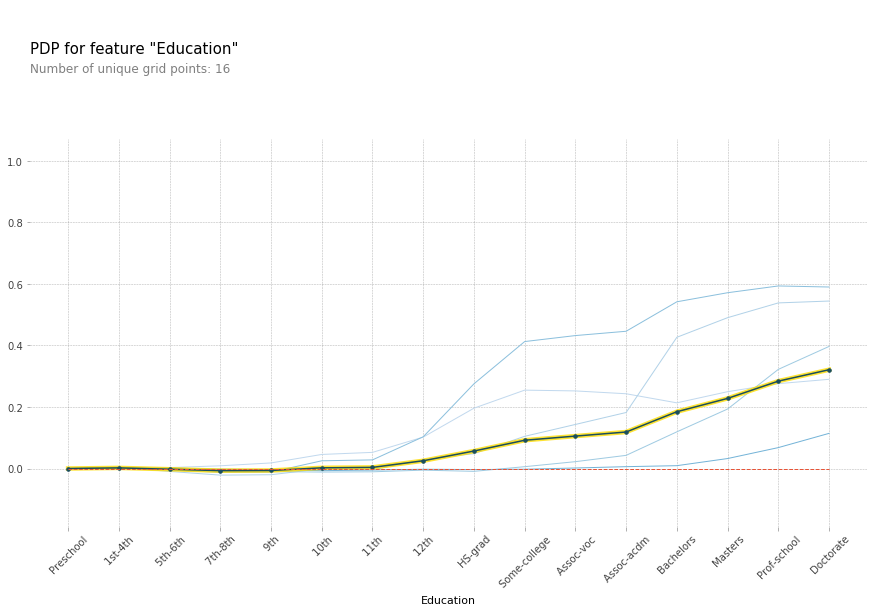

In [332]:
# Ahora veamos como reacciona el modelo a esta variable
pdp_education = pdp.pdp_isolate(m, x_train, x_train.columns, 'education',
                                grid_type='equal', num_grid_points=x_train.education.nunique())
fig, axes = pdp.pdp_plot(pdp_education, 'Education', cluster=True, n_cluster_centers=5)
axes['pdp_ax'].set_xticks(np.arange(len(education_lbls))+1)
axes['pdp_ax'].set_xticklabels(education_lbls, rotation=45);

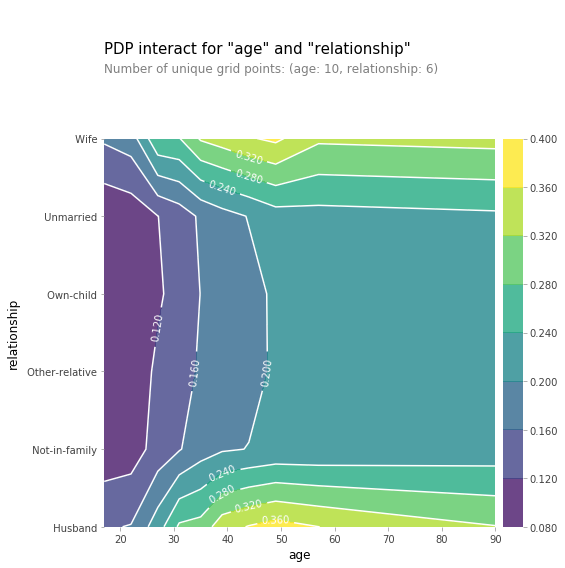

In [314]:
pdp_age_rel = pdp.pdp_interact(m, x_train, x_train.columns, ['age', 'relationship'],
                               num_grid_points=[10, x_train.relationship.nunique()],
                               grid_types=['percentile', 'equal'])
fig, axes = pdp.pdp_interact_plot(pdp_age_rel, ['age', 'relationship'], plot_pdp=False)
axes['pdp_inter_ax'].set_yticklabels([cat_dict['relationship'][e+1] for e in range(x_train.relationship.nunique())]);

In [378]:
from treeinterpreter import treeinterpreter as ti

sample = x_val.sample()
print(f'Real label = {y_val[sample.index[0]]}')
sample

Real label =  <=50K


,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
12587,25,5,155320,13,5,5,4,5,2,0,0,45,40


In [379]:
preds, bias, contributions = ti.predict(m, sample)
pred = np.argmax(preds)
pred

0

In [372]:
bias[0,pred]

0.7596226197788698

In [376]:
contributions[0,:,pred]

array([ 0.02581297,  0.00284996,  0.00498336,  0.03576307, -0.01343717,
        0.012149  ,  0.09661091,  0.00013595,  0.02364208,  0.020204  ,
        0.00536349,  0.02505741,  0.00124234])

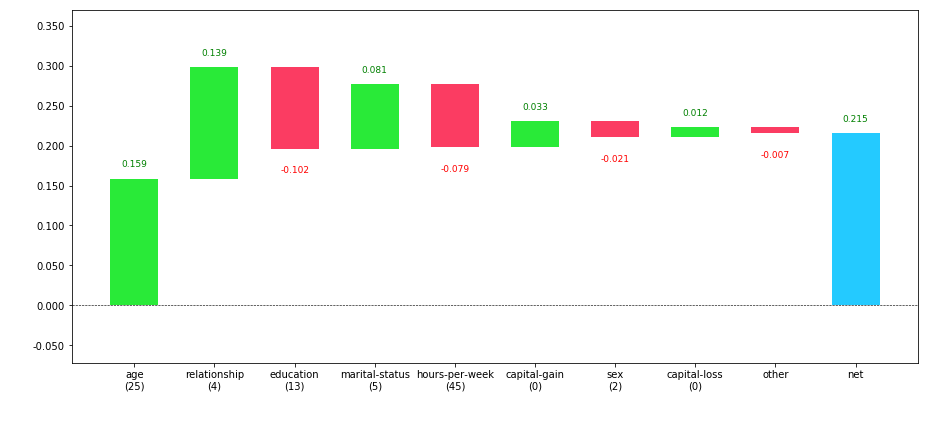

In [380]:
# Usamos un waterfallplot para tener una mejor visualización de la predicción
utils.waterfallplot(sample, contributions[0,:,pred], formatting='{:,.3f}', size=(13,6), sorted_value=True, threshold=0.05);

# Revisitando Train-validation split

In [336]:
# Cargar la data del ejemplo de regresión
df = df_raw.sort_values('date_elapsed')
x = df.drop('price', axis=1)
y = df['price']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=False)
print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (17290, 30)
Validation shape: (4323, 30)


In [337]:
m = RandomForestRegressor(40, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

**Last score**:

* Train score      = 0.9833
* Validation score = 0.8884
* OOB score        = 0.879

In [338]:
score()

Scores:
Train      = 0.9839
Validation = 0.8557
OOB        = 0.8846


# Debilidades de Random Forest

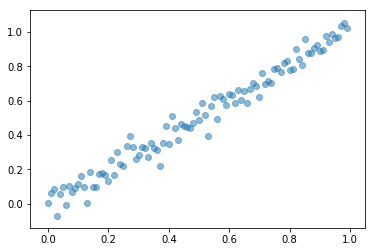

In [99]:
x = np.arange(100)/100
y = x + np.random.normal(scale=0.05, size=100)

plt.scatter(x, y, alpha=0.5);

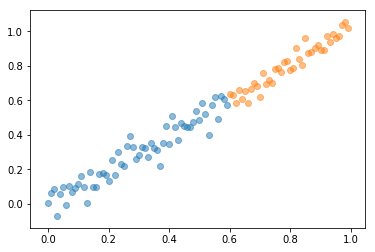

In [100]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.4, shuffle=False)
plt.scatter(x_train, y_train, alpha=0.5)
plt.scatter(x_val, y_val, alpha=0.5);

In [105]:
x_train.shape

(60,)

In [104]:
# Para poder entrenar la data, esta tiene que tener 2 dimensiones
x_train[:, None].shape

(60, 1)

In [107]:
x_train = x_train[:, None]
x_val = x_val[:, None]

In [111]:
m = RandomForestRegressor(40, oob_score=True)
m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [112]:
score()

Scores:
Train      = 0.9776
Validation = -2.581
OOB        = 0.8479


Examinemos los resultados

In [113]:
pred_train = m.predict(x_train)
pred_val = m.predict(x_val)

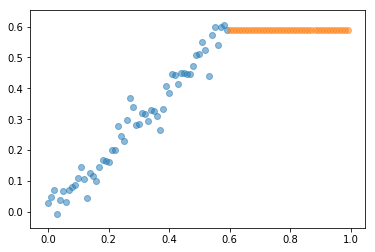

In [114]:
plt.scatter(x_train, pred_train, alpha=0.5)
plt.scatter(x_val, pred_val, alpha=0.5);